In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import tensorboard as tb
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
from tqdm import tqdm

In [11]:
# https://github.com/theRealSuperMario/supermariopy/blob/master/scripts/tflogs2pandas.py
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data


def many_logs2pandas(event_paths):
    all_logs = pd.DataFrame()
    for path in event_paths:
        log = tflog2pandas(path)
        if log is not None:
            if all_logs.shape[0] == 0:
                all_logs = log
            else:
                all_logs = all_logs.append(log, ignore_index=True)
    return all_logs

In [12]:
def load_models(dir):
    all_logs = pd.DataFrame()
    models = next(os.walk(dir))[1]
    for model in tqdm(models):
        model_path = os.path.join(dir, model)
        runs = next(os.walk(model_path))[1]
        for run in runs:
            path = os.path.join(model_path, run)
            log = tflog2pandas(path)
            log['run'] = run
            log['model'] = model
            # string_splits = run.split('_')
            # log['tag'] = string_splits[0]
            # log['model'] = string_splits[1]
            # hp = ', '.join(string_splits[2:-3])
            # if string_splits[1] == 'GecoVAE':
            #     hp = hp.replace(", 255,", ",")
            #     hp = hp.replace("lambda, init", "lambda_init")
            # log['hyperparams'] = hp
            # log['seed'] = string_splits[-3][4:]
            # log['date'] = string_splits[-2] + "_" + string_splits[-1]

            if log is not None:
                if all_logs.shape[0] == 0:
                    all_logs = log
                else:
                    all_logs = all_logs.append(log, ignore_index=True)


    # create dataframe with final values
    # dff = all_logs[all_logs.step == all_logs.step.max()]
    # dff = dff.pivot_table(index=["run", "tag", "model", "hyperparams", "seed", "date"], columns=["metric"],values="value")
    # dff = pd.DataFrame(dff.to_records())
    return all_logs #, dff

In [13]:
# dir = './carla/agents/data/'
# df = load_models(dir)

100%|██████████| 39/39 [09:27<00:00, 14.55s/it]


In [31]:
# df.to_pickle("temp.pkl")

In [14]:
df

,metric,value,step,run,model
0,stats/EpRet,-0.428372,0.0,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...
1,stats/EpRet,-0.030000,1.0,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...
2,stats/EpRet,-0.193077,2.0,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...
3,stats/EpRet,-0.334898,3.0,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...
4,stats/EpRet,-0.474255,4.0,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...
...,...,...,...,...,...
12033915,eval_stats/context_89/GoalReached,1.000000,55.0,nc_s44864,nc
12033916,eval_stats/context_89/GoalReached,1.000000,56.0,nc_s44864,nc
12033917,eval_stats/context_89/GoalReached,1.000000,57.0,nc_s44864,nc
12033918,eval_stats/context_89/GoalReached,1.000000,58.0,nc_s44864,nc


In [25]:
a = df
a = a[a.metric == "eval_stats/AvgEpRet"]
a = a[a.step == a.step.max()]


In [28]:
a.sort_values("value")

,metric,value,step,run,model
1919439,eval_stats/AvgEpRet,1.518928,59.0,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...
8113434,eval_stats/AvgEpRet,2.268311,59.0,carlac_frozenvae_GecoVAE_tolerance10.0_255_lam...,carlac_frozenvae_GecoVAE_tolerance10.0_255_lam...
11829769,eval_stats/AvgEpRet,2.330034,59.0,nc_s26912,nc
4397029,eval_stats/AvgEpRet,2.409311,59.0,carlac_frozenvae_BetaVAE_beta1.0_seed787727006...,carlac_frozenvae_BetaVAE_beta1.0_seed787727006
6520679,eval_stats/AvgEpRet,2.497917,59.0,carlac_frozenvae_BetaVAE_beta5.0_seed171041946...,carlac_frozenvae_BetaVAE_beta5.0_seed171041946
...,...,...,...,...,...
3335234,eval_stats/AvgEpRet,2.720022,59.0,carlac_frozenvae_beta10_seed171041946_s44864,carlac_frozenvae_beta10_seed171041946
6166739,eval_stats/AvgEpRet,2.722144,59.0,carlac_frozenvae_BetaVAE_beta20.0_seed78772700...,carlac_frozenvae_BetaVAE_beta20.0_seed787727006
8821309,eval_stats/AvgEpRet,2.747844,59.0,carlac_frozenvae_GecoVAE_tolerance10.0_255_lam...,carlac_frozenvae_GecoVAE_tolerance10.0_255_lam...
11475834,eval_stats/AvgEpRet,2.751711,59.0,carlac_frozenvae_GecoVAE_tolerance5.0_255_lamb...,carlac_frozenvae_GecoVAE_tolerance5.0_255_lamb...


Text(0.5, 1.0, 'AvgEpRet at final step')

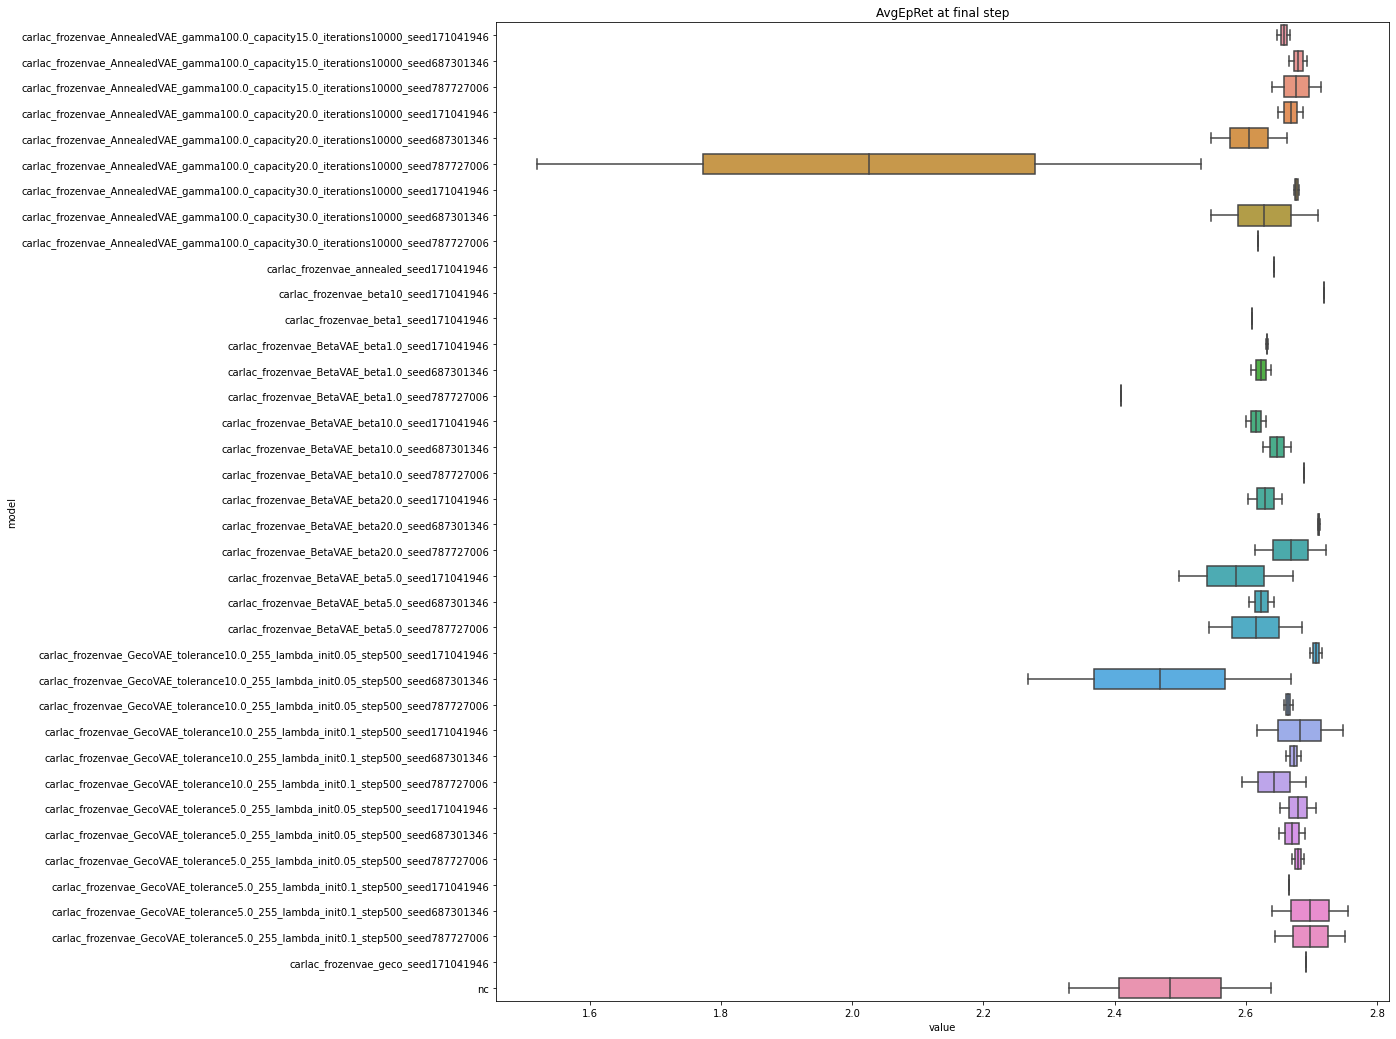

In [30]:
plt.figure(figsize=(16, 18))
sns.boxplot(data=a, y=a.model, x=a.value).set_title("AvgEpRet at final step")


In [39]:
import re
a['model_arch'] = a.model.apply(lambda x: None if x == 'nc' else re.findall(r'carlac_frozenvae_(\w+)_',x)[0])
a['model_hp'] = a.model.apply(lambda x: None if x == 'nc' else re.findall(r'carlac_frozenvae_[^_]+(.*)_seed',x)[0])

In [41]:
df_mean = a.groupby(["model_arch","model_hp"]).mean()

In [42]:
df_mean

value  step
model_arch  model_hp                                                  
AnnealedVAE _gamma100.0_capacity15.0_iterations10000    2.671723  59.0
            _gamma100.0_capacity20.0_iterations10000    2.432886  59.0
            _gamma100.0_capacity30.0_iterations10000    2.646274  59.0
BetaVAE     _beta1.0                                    2.584407  59.0
            _beta10.0                                   2.643219  59.0
            _beta20.0                                   2.669885  59.0
            _beta5.0                                    2.608079  59.0
GecoVAE     _tolerance10.0_255_lambda_init0.05_step500  2.613709  59.0
            _tolerance10.0_255_lambda_init0.1_step500   2.666075  59.0
            _tolerance5.0_255_lambda_init0.05_step500   2.676559  59.0
            _tolerance5.0_255_lambda_init0.1_step500    2.692116  59.0
annealed                                                2.643456  59.0
beta1                                                   2.609944  59.0
beta10                                                  2.720022  59.0
geco                                                    2.691317  59.0

In [44]:
green = sns.light_palette("green", as_cmap=True)
df_mean.style\
    .background_gradient(cmap=green, subset=['value'])

In [53]:
df_std = a[a.model_hp != ''].groupby(["model_arch","model_hp"]).agg({'value': ['mean', 'std']})

In [58]:
df_std

value          
                                                            mean       std
model_arch  model_hp                                                      
AnnealedVAE _gamma100.0_capacity15.0_iterations10000    2.671723  0.028039
            _gamma100.0_capacity20.0_iterations10000    2.432886  0.452244
            _gamma100.0_capacity30.0_iterations10000    2.646274  0.064145
BetaVAE     _beta1.0                                    2.584407  0.098551
            _beta10.0                                   2.643219  0.035571
            _beta20.0                                   2.669885  0.052417
            _beta5.0                                    2.608079  0.074311
GecoVAE     _tolerance10.0_255_lambda_init0.05_step500  2.613709  0.170580
            _tolerance10.0_255_lambda_init0.1_step500   2.666075  0.055288
            _tolerance5.0_255_lambda_init0.05_step500   2.676559  0.022927
            _tolerance5.0_255_lambda_init0.1_step500    2.692116  0.057458